In [1]:
# ORB (Oriented FAST and Rotated BRIEF) + Brute-Force Matcher with Hamming Distance

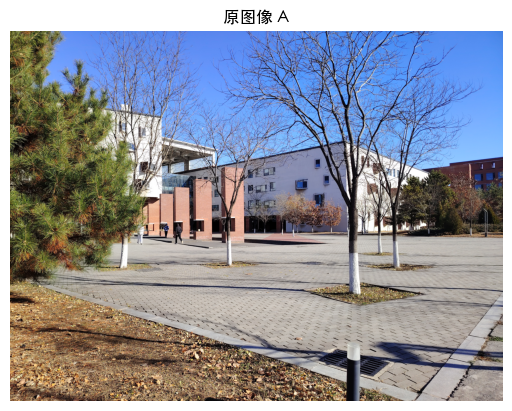

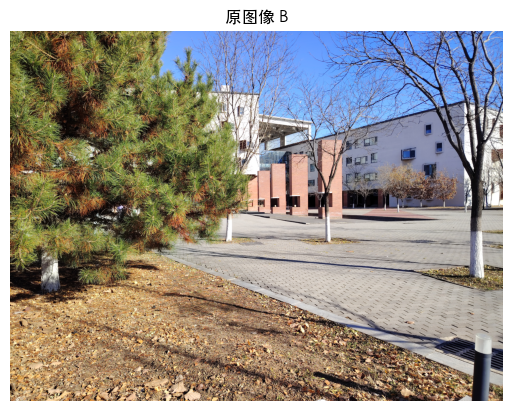

[detectAndDescribe] 检测到 500 个特征点，耗时: 0.2139 秒
[detectAndDescribe] 检测到 500 个特征点，耗时: 0.1779 秒
图像 A 的特征点数量: 500
图像 B 的特征点数量: 500


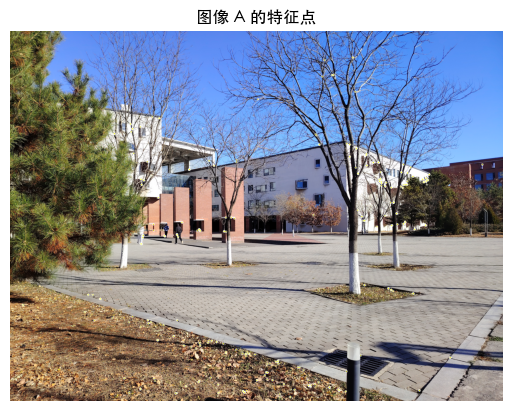

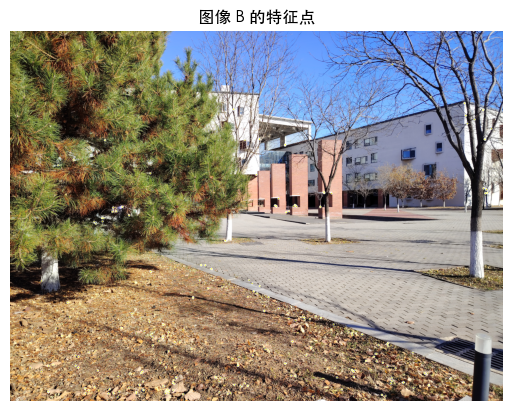

[match_keypoints_with_orb] 匹配到 182 个特征对，平均匹配距离: 46.80, 耗时: 0.0007 秒
最终有效匹配点数: 182
平均匹配距离: 46.80


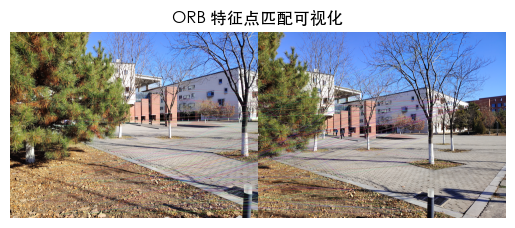

[stitch_images] 内点数量: 75/182，内点比例: 0.41


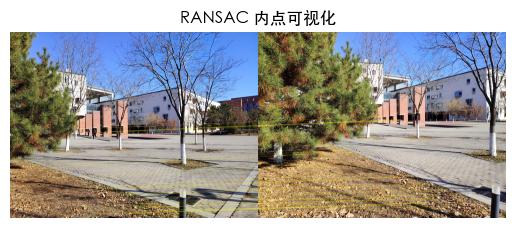

[stitch_images] 拼接完成，耗时: 0.6417 秒


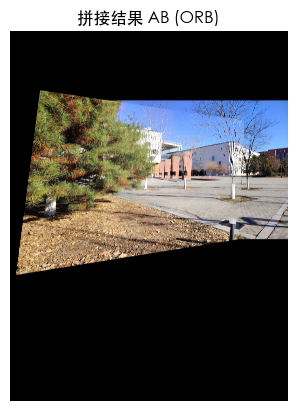

拼接结果已保存至: ./output_ORB/stitched_ORB_Hamming_3_4.jpg


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time  # <-- 如果需要统计耗时

# 设置全局字体
plt.rcParams['font.sans-serif'] = ['STHeiti']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ============================
# 配置参数
# ============================

imageA_path = "../datasets/new_data/3.jpg"  # 图像 A 的路径
imageB_path = "../datasets/new_data/4.jpg"  # 图像 B 的路径

ransac_threshold = 5         # RANSAC 阈值
min_matches_required = 4     # 计算单应矩阵所需的最小匹配点数量
gaussian_kernel_size = (7, 7)  # 高斯模糊的内核大小

def show_image(image, title="Image"):
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detectAndDescribe(image):
    """
    使用 ORB 进行特征点检测与描述符提取，包含:
    1) 转灰度
    2) 高斯模糊去噪
    3) ORB 特征检测和描述
    """
    # 如果需要统计该函数耗时，可以这样：
    start_time = time.time()

    # 1) 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2) 高斯模糊
    denoised = cv2.GaussianBlur(gray, gaussian_kernel_size, 0)

    # 3) 使用 ORB 提取特征
    orb = cv2.ORB_create()
    kps, des = orb.detectAndCompute(denoised, None)
    kps_float = np.float32([kp.pt for kp in kps])

    end_time = time.time()
    print(f"[detectAndDescribe] 检测到 {len(kps)} 个特征点，耗时: {end_time - start_time:.4f} 秒")

    return kps, kps_float, des

def match_keypoints_with_orb(desA, desB):
    """
    使用 BFMatcher (Hamming 距离, crossCheck=True) 进行 ORB 特征匹配
    并在这里示范如何计算匹配距离的平均值。
    """
    start_time = time.time()

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(desA, desB)

    # 计算平均距离（可选）
    distances = [m.distance for m in matches]
    avg_distance = np.mean(distances) if len(distances) > 0 else -1

    end_time = time.time()
    print(f"[match_keypoints_with_orb] 匹配到 {len(matches)} 个特征对，"
          f"平均匹配距离: {avg_distance:.2f}, 耗时: {end_time - start_time:.4f} 秒")

    # 返回结果时，需要转换为适配 cv2.drawMatchesKnn 的格式
    good_matches = [[m] for m in matches]
    match_idx_pairs = [(m.queryIdx, m.trainIdx) for m in matches]

    return good_matches, match_idx_pairs, avg_distance

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    """
    可视化匹配结果
    """
    vis = cv2.drawMatchesKnn(
        imageB, kpsB,
        imageA, kpsA,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return vis

def stitch_images(center_image, align_image, center_kps_float, align_kps_float, matches):
    """
    根据匹配点计算单应矩阵，并执行图像拼接
    这里还演示如何统计内点数量和内点比例
    """
    if len(matches) <= min_matches_required:
        print(f"匹配点不足（需要至少 {min_matches_required} 个）")
        return None
    
    start_time = time.time()

    pts_center = np.float32([center_kps_float[i] for (i, _) in matches])
    pts_align = np.float32([align_kps_float[j] for (_, j) in matches])

    # 计算单应性矩阵
    H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)
    if status is None:
        print("[stitch_images] RANSAC 计算失败，无法获得单应矩阵。")
        return None

    # 内点统计
    inlier_count = np.sum(status)
    total_count = len(matches)
    inlier_ratio = inlier_count / float(total_count)
    print(f"[stitch_images] 内点数量: {inlier_count}/{total_count}，内点比例: {inlier_ratio:.2f}")

    # 可视化内点
    inlier_pts_center = pts_center[status.ravel() == 1]
    inlier_pts_align = pts_align[status.ravel() == 1]

    combined_image = np.hstack((center_image, align_image))
    offset = center_image.shape[1]
    for ptC, ptA in zip(inlier_pts_center, inlier_pts_align):
        ptC = (int(ptC[0]), int(ptC[1]))
        ptA = (int(ptA[0] + offset), int(ptA[1]))
        cv2.circle(combined_image, ptC, 5, (0, 255, 0), -1)
        cv2.circle(combined_image, ptA, 5, (255, 0, 0), -1)
        cv2.line(combined_image, ptC, ptA, (0, 255, 255), 1)
    show_image(combined_image, "RANSAC 内点可视化")

    # 执行拼接
    height_center, width_center = center_image.shape[:2]
    canvas_size = (height_center * 2, width_center * 2)
    translation_dist = (canvas_size[1] // 4, canvas_size[0] // 4)
    H_translation = np.array([
        [1, 0, translation_dist[0]],
        [0, 1, translation_dist[1]],
        [0, 0, 1]], dtype=np.float32)

    result = cv2.warpPerspective(center_image, H_translation, canvas_size)
    H_combined = H_translation @ H
    warped_align = cv2.warpPerspective(align_image, H_combined, canvas_size)
    result = np.maximum(result, warped_align)

    end_time = time.time()
    print(f"[stitch_images] 拼接完成，耗时: {end_time - start_time:.4f} 秒")

    return result

def show_keypoints(image, keypoints, title="Keypoints"):
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 8, (255, 255, 255), 2)
        cv2.circle(image_with_keypoints, (x, y), 4, (0, 255, 255), -1)
    show_image(image_with_keypoints, title)

# ============================
# 主流程
# ============================
if __name__ == "__main__":
    imageA = cv2.imread(imageA_path)
    imageB = cv2.imread(imageB_path)

    if imageA is None or imageB is None:
        print("Error: Could not load one or both images.")
    else:
        show_image(imageA, '原图像 A')
        show_image(imageB, '原图像 B')

        # 提取特征点和描述符
        kpsA, kps_floatA, desA = detectAndDescribe(imageA)
        kpsB, kps_floatB, desB = detectAndDescribe(imageB)

        # 输出特征点数量
        print(f"图像 A 的特征点数量: {len(kpsA)}")
        print(f"图像 B 的特征点数量: {len(kpsB)}")

        # 显示特征点可视化
        show_keypoints(imageA, kpsA, '图像 A 的特征点')
        show_keypoints(imageB, kpsB, '图像 B 的特征点')

        # 匹配
        good_matches_AB, matches_AB, avg_dist_AB = match_keypoints_with_orb(desA, desB)

        # 在控制台输出一些匹配指标
        print(f"最终有效匹配点数: {len(good_matches_AB)}")
        if avg_dist_AB > 0:
            print(f"平均匹配距离: {avg_dist_AB:.2f}")

        # 显示匹配结果
        vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
        if vis_AB is not None:
            show_image(vis_AB, 'ORB 特征点匹配可视化')

        # 拼接
        stitchedAB = stitch_images(imageA, imageB, kps_floatA, kps_floatB, matches_AB)
        if stitchedAB is not None:
            show_image(stitchedAB, '拼接结果 AB (ORB)')

            # 保存拼接结果
            baseA = os.path.basename(imageA_path)[-7:-4]
            baseB = os.path.basename(imageB_path)[-7:-4]
            output_filename = f"./output_ORB/stitched_ORB_Hamming_{baseA}_{baseB}.jpg"
            os.makedirs('./output_ORB', exist_ok=True)
            cv2.imwrite(output_filename, stitchedAB)
            print(f"拼接结果已保存至: {output_filename}")
        else:
            print("拼接失败：匹配点不足或其他问题。")